<a href="https://colab.research.google.com/github/ArunKrishnan09/dl-survey-live-lab-2025/blob/main/notebooks/01_baseline_random_forest_gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 — Baseline Random Forest (Student)

**Today we will:**
1) Load the Adult dataset (classification: `income`).
2) Split train/test **first** (avoid leakage).
3) Handle missing values (numeric: mean; categorical: most frequent).
4) Encode categorical features:
   - Label encode **one** column (`sex`)
   - One-hot encode the rest
5) (Practice) Scale numeric features (StandardScaler).
6) Train a **RandomForestClassifier** and evaluate it.
7) **Deep dive** into the RF object: attributes & methods.
8) Try a few hyperparameters and record results in your `students/experiment_log.md`.
9) Peek at **GridSearchCV** (teacher-led demo).

> As you work: add short notes in your experiment log (Goal → Setup → Results → Reflection).


### Setup

In [1]:
# 0) Setup
!pip -q install scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import fetch_openml

print("Ready.")


Ready.


### Load data

In [2]:
# 1) Load the Adult dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame.copy()
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


**Question:** Is this a classification or regression problem?  
**Target column:** ???


### Choose columns & split FIRST

In [3]:
# 2) Choose columns (keep it small for speed)
numeric_features = ["age", "hours-per-week", "education-num", "capital-gain", "capital-loss"]
categorical_features = ["workclass", "marital-status", "occupation", "sex", "native-country"]
target_col = "class"

use_cols = numeric_features + categorical_features + [target_col]
df = df[use_cols].copy()

# 3) Split FIRST (to avoid leakage)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((39073, 10), (9769, 10))

In [4]:
X_train

,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
34342,71,17,9,0,0,Private,Never-married,Handlers-cleaners,Male,United-States
18559,17,10,6,0,0,Private,Never-married,Sales,Female,United-States
12477,27,40,9,0,0,Private,Married-civ-spouse,Other-service,Male,El-Salvador
560,43,40,9,0,0,Private,Separated,Adm-clerical,Female,United-States
3427,31,40,13,0,0,Private,Married-civ-spouse,Exec-managerial,Male,United-States
...,...,...,...,...,...,...,...,...,...,...
38073,33,60,9,0,0,Private,Married-civ-spouse,Sales,Male,United-States
16306,56,40,13,0,0,Local-gov,Married-civ-spouse,Tech-support,Male,United-States
26860,36,40,10,0,0,Private,Married-civ-spouse,Machine-op-inspct,Male,United-States
20602,32,40,9,0,0,Private,Married-civ-spouse,Adm-clerical,Male,United-States


In [5]:
y_train

,class
34342,<=50K
18559,<=50K
12477,<=50K
560,<=50K
3427,<=50K
...,...
38073,>50K
16306,>50K
26860,>50K
20602,<=50K


**Why split first?**  
So that ....


### Handle missing values

In [6]:
# 4) Impute missing values
# Numeric → mean (try median later if you like)
num_imputer = SimpleImputer(strategy="mean")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_features]),
                           columns=numeric_features, index=X_train.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test[numeric_features]),
                           columns=numeric_features, index=X_test.index)

# Categorical → most frequent
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_raw = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_features]),
                               columns=categorical_features, index=X_train.index)
X_test_cat_raw  = pd.DataFrame(cat_imputer.transform(X_test[categorical_features]),
                               columns=categorical_features, index=X_test.index)


### Encode categoricals

In [7]:
# 5) Encode categoricals
# Label-encode ONE column ('sex'); one-hot the rest
label_encode_col = "sex"

# Copies
X_train_processed = X_train_cat_raw.copy()
X_test_processed  = X_test_cat_raw.copy()

# LabelEncoder: fit on train, apply to test
le = LabelEncoder()
X_train_processed[label_encode_col] = le.fit_transform(X_train_processed[label_encode_col])
X_test_processed[label_encode_col]  = le.transform(X_test_processed[label_encode_col])

# One-hot all other categorical columns
onehot_cols = [c for c in X_train_processed.columns if c != label_encode_col]

# Version-safe: sparse_output (>=1.2) vs sparse (<1.2)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_train_ohe_array = ohe.fit_transform(X_train_processed[onehot_cols])
X_test_ohe_array  = ohe.transform(X_test_processed[onehot_cols])

ohe_feature_names = ohe.get_feature_names_out(onehot_cols)
X_train_ohe = pd.DataFrame(X_train_ohe_array, columns=ohe_feature_names)
X_test_ohe  = pd.DataFrame(X_test_ohe_array,  columns=ohe_feature_names)

# Combine label-encoded + one-hot (reset indices for alignment)
label_encoded_train = X_train_processed[[label_encode_col]].reset_index(drop=True)
label_encoded_test  = X_test_processed[[label_encode_col]].reset_index(drop=True)
X_train_cat = pd.concat([label_encoded_train, X_train_ohe.reset_index(drop=True)], axis=1)
X_test_cat  = pd.concat([label_encoded_test,  X_test_ohe.reset_index(drop=True)],  axis=1)

X_train_cat.shape, X_test_cat.shape


((39073, 71), (9769, 71))

**Reflect:**  
- When might **label encoding** be risky?  
- Why is **one-hot** often safer for models like Logistic Regression or Neural Nets?


### Scale numeric features (practice)

In [8]:
# 6) Scale numeric features (practice—even if RF doesn’t need it)
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numeric_features)
X_test_num_scaled  = pd.DataFrame(scaler.transform(X_test_num),   columns=numeric_features)

# Assemble final matrices (reset indices to align rows)
X_train_final = pd.concat([X_train_num_scaled.reset_index(drop=True),
                           X_train_cat.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test_num_scaled.reset_index(drop=True),
                           X_test_cat.reset_index(drop=True)],  axis=1)

X_train_final.shape, X_test_final.shape


((39073, 76), (9769, 76))

**When would you prefer**:
- `MinMaxScaler` ?
- `RobustScaler` ?


### Train RF + Evaluate

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7431
        >50K       0.72      0.61      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



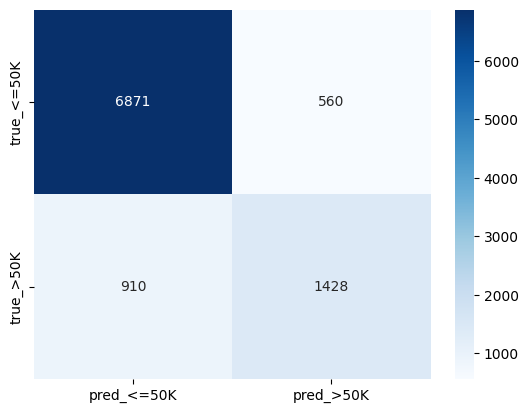

In [9]:
# 7) Train a baseline Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train)

y_pred = rf.predict(X_test_final)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
sns.heatmap(pd.DataFrame(cm, index=[f"true_{c}" for c in rf.classes_],
                            columns=[f"pred_{c}" for c in rf.classes_]),
            annot=True, fmt="d", cmap="Blues")
plt.show()


### Deep dive: RF Object

In [10]:
# 8) Inspect the RF object: attributes & methods
print("Number of trees:", rf.n_estimators)
print("Classes:", rf.classes_)
print("Max depth setting:", rf.max_depth)

# Feature importances (top 10)
importances = pd.Series(rf.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
importances.head(10)


Number of trees: 100
Classes: ['<=50K' '>50K']
Max depth setting: None


,0
age,0.250227
education-num,0.136151
hours-per-week,0.124182
capital-gain,0.115856
marital-status_Married-civ-spouse,0.112690
capital-loss,0.041463
marital-status_Never-married,0.036695
sex,0.021219
occupation_Exec-managerial,0.019455
marital-status_Divorced,0.011493


In [11]:
# Predict vs predict_proba
pred_label = rf.predict(X_test_final[:5])
pred_prob  = rf.predict_proba(X_test_final[:5])
pred_label, pred_prob


(array(['>50K', '<=50K', '>50K', '<=50K', '>50K'], dtype=object),
 array([[0.44, 0.56],
        [1.  , 0.  ],
        [0.34, 0.66],
        [0.88, 0.12],
        [0.35, 0.65]]))

**Explain in your own words:**  
- What’s the difference between `predict` and `predict_proba`?  
- Which would you show in an app UI, and why?


### Tinkering with Hyperparameters

In [12]:
# 9) Tinker: try one change, re-run report, log in experiment_log.md
rf2 = RandomForestClassifier(
    n_estimators=200,   # try 50 / 100 / 200
    max_depth=None,     # try 10 / 20 / None
    min_samples_split=2,  # try 2 / 5
    random_state=42
)
rf2.fit(X_train_final, y_train)
print(classification_report(y_test, rf2.predict(X_test_final)))


              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      7431
        >50K       0.72      0.61      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



### GridSearchCV

In [13]:
# 10)
from sklearn.model_selection import GridSearchCV
"""
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
}
grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_final, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", round(grid.best_score_, 4))
print("Test accuracy with best params:", round(grid.best_estimator_.score(X_test_final, y_test), 4))
"""

'\nparam_grid = {\n    "n_estimators": [50, 100],\n    "max_depth": [None, 10, 20],\n}\ngrid = GridSearchCV(RandomForestClassifier(random_state=42),\n                    param_grid, cv=3, scoring="accuracy", n_jobs=-1)\ngrid.fit(X_train_final, y_train)\n\nprint("Best params:", grid.best_params_)\nprint("Best CV accuracy:", round(grid.best_score_, 4))\nprint("Test accuracy with best params:", round(grid.best_estimator_.score(X_test_final, y_test), 4))\n'

# 🏠 Homework: GridSearchCV vs RandomizedSearchCV

Today we used **GridSearchCV** to systematically test a small parameter grid.  
But GridSearch gets expensive if the parameter space is large.  
An alternative is **RandomizedSearchCV**: it samples combinations at random.

**Task:**  
1. Run the provided code that compares GridSearchCV and RandomizedSearchCV.  
2. Note which one is faster, and whether they found similar/better hyperparameters.  
3. Add your reflection in `students/experiment_log.md` under "Run 2".


In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
"""
# Define parameter distributions for RandomizedSearch
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10)
}

# GridSearch (small grid)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, scoring="accuracy", n_jobs=-1)

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                   param_dist, n_iter=10, cv=3,
                                   scoring="accuracy", n_jobs=-1,
                                   random_state=42)

print("Running GridSearchCV...")
grid.fit(X_train_final, y_train)

print("Running RandomizedSearchCV...")
random_search.fit(X_train_final, y_train)

print("Best params (GridSearch):", grid.best_params_)
print("Best score (GridSearch):", round(grid.best_score_, 4))

print("Best params (RandomizedSearch):", random_search.best_params_)
print("Best score (RandomizedSearch):", round(random_search.best_score_, 4))
"""


'\n# Define parameter distributions for RandomizedSearch\nparam_dist = {\n    "n_estimators": randint(50, 300),\n    "max_depth": [None, 10, 20, 30],\n    "min_samples_split": randint(2, 10)\n}\n\n# GridSearch (small grid)\nparam_grid = {\n    "n_estimators": [50, 100, 200],\n    "max_depth": [None, 10, 20],\n}\n\ngrid = GridSearchCV(RandomForestClassifier(random_state=42),\n                    param_grid, cv=3, scoring="accuracy", n_jobs=-1)\n\nrandom_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),\n                                   param_dist, n_iter=10, cv=3,\n                                   scoring="accuracy", n_jobs=-1,\n                                   random_state=42)\n\nprint("Running GridSearchCV...")\ngrid.fit(X_train_final, y_train)\n\nprint("Running RandomizedSearchCV...")\nrandom_search.fit(X_train_final, y_train)\n\nprint("Best params (GridSearch):", grid.best_params_)\nprint("Best score (GridSearch):", round(grid.best_score_, 4))\n\nprint("Best

## Reflection Questions
- Which method finished faster? Why?  
- Did they find similar or different best parameters?  
- When would you choose GridSearchCV vs RandomizedSearchCV in practice?  


# 🎛️ Turn Your Random Forest Into a Gradio App

**Goal:** Wrap our already-trained Random Forest (RF) into a tiny web app so anyone can try inputs and see predictions (and confidence).

**What you should already have (from the earlier notebook):**
- A trained `rf` model.
- Preprocessing objects: `num_imputer`, `cat_imputer`, `le` (LabelEncoder for `"sex"`), `ohe`, `scaler`.
- Feature lists: `numeric_features`, `label_encode_col = "sex"`, `onehot_cols`.
- The final training matrix `X_train_final` (so we can keep the exact column order).

> If you get “name is not defined” errors later, scroll up and re-run the cells that define/train these.





---

## Step 1 — Lock in the feature order
We must feed the app’s processed row to the model in the **exact** column order used during training.

**Action:** Create `feature_order = list(X_train_final.columns)` in a code cell.

**Why:** Prevents misalignment (wrong columns → wrong predictions).



In [15]:
feature_order = list(X_train_final.columns)  # numeric (scaled) + categorical block


In [16]:
feature_order

['age',
 'hours-per-week',
 'education-num',
 'capital-gain',
 'capital-loss',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'marital-status_Divorced',
 'marital-status_Married-AF-spouse',
 'marital-status_Married-civ-spouse',
 'marital-status_Married-spouse-absent',
 'marital-status_Never-married',
 'marital-status_Separated',
 'marital-status_Widowed',
 'occupation_Adm-clerical',
 'occupation_Armed-Forces',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Other-service',
 'occupation_Priv-house-serv',
 'occupation_Prof-specialty',
 'occupation_Protective-serv',
 'occupation_Sales',
 'occupation_Tech-support',
 'occupation_Transport-moving',
 'native-country_Cambodia',
 'native-country_Canada',
 'nat

---

## Step 2 — Install & import Gradio
We’ll use Gradio to make a small UI with sliders/dropdowns.

**Action:**  
- `!pip -q install gradio`  
- `import gradio as gr` (+ `pandas`, `numpy` if needed)

**Why:** Gradio handles the interface so we focus on ML logic.



In [17]:
!pip -q install gradio
import gradio as gr
#import pandas as pd
#import numpy as np


---

## Step 3 — Write a `preprocess_input(user_dict)` helper
This function should:
1. Build a one-row `DataFrame` from the raw UI inputs.
2. **Numeric**: impute with `num_imputer` → scale with `scaler`.
3. **Categorical**: impute with `cat_imputer` → label-encode the `"sex"` column with `le` → one-hot the rest with `ohe`.
4. Concatenate numeric + categorical.
5. Add any missing columns (fill with 0) and **reorder** using `feature_order`.
6. Return a 1-row `DataFrame` ready for `rf.predict` / `rf.predict_proba`.

**Why:** The app must apply **the same preprocessing** as training, learned on the train split only.



In [18]:
def preprocess_input(user_dict):
    """
    Apply the SAME transforms as train-time to a single-row user_dict and
    return a 1-row DataFrame with columns exactly matching feature_order.
    """
    # 1) Raw one-row frame
    df_in = pd.DataFrame([user_dict])
    #print(df_in)
    # 2) Numeric -> impute -> scale
    Xn = pd.DataFrame(num_imputer.transform(df_in[numeric_features]),
                      columns=numeric_features)
    Xn_scaled = pd.DataFrame(scaler.transform(Xn), columns=numeric_features)

    # 3) Categorical -> impute -> label-encode ONE col -> one-hot the rest
    df_cat = df_in[categorical_features].copy()
    df_cat = pd.DataFrame(cat_imputer.transform(df_cat),
                          columns=categorical_features) # ERROR HERE CATEGORICAL

    # Label-encode the chosen column (assumes no unseen categories)
    df_cat[label_encode_col] = le.transform(df_cat[label_encode_col])


    # one-hot the remaining categoricals (trained with handle_unknown="ignore")
    Xc_ohe = pd.DataFrame(
        ohe.transform(df_cat[onehot_cols]),
        columns=ohe.get_feature_names_out(onehot_cols)
    )

    # final categorical block = label-encoded col + one-hot block
    Xc_final = pd.concat(
        [df_cat[[label_encode_col]].reset_index(drop=True),
         Xc_ohe.reset_index(drop=True)],
        axis=1
    )

    # 4) Assemble numeric + categorical
    X_final = pd.concat(
        [Xn_scaled.reset_index(drop=True), Xc_final.reset_index(drop=True)],
        axis=1
    )

    # 5) Enforce EXACT training columns & order in ONE step
    # - drops any extra columns
    # - inserts any missing one-hot columns filled with 0
    #X_final = X_final.reindex(columns=feature_order, fill_value=0)
    # at end of preprocess_input
    expected_cols = list(getattr(rf, "feature_names_in_", feature_order))
    X_final = X_final.reindex(columns=expected_cols, fill_value=0)
    return X_final


    #return X_final


In [19]:
categorical_features

['workclass', 'marital-status', 'occupation', 'sex', 'native-country']

In [20]:
X_train.head()

,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
34342,71,17,9,0,0,Private,Never-married,Handlers-cleaners,Male,United-States
18559,17,10,6,0,0,Private,Never-married,Sales,Female,United-States
12477,27,40,9,0,0,Private,Married-civ-spouse,Other-service,Male,El-Salvador
560,43,40,9,0,0,Private,Separated,Adm-clerical,Female,United-States
3427,31,40,13,0,0,Private,Married-civ-spouse,Exec-managerial,Male,United-States


In [21]:
test = {
    "age": 20,
    "hours-per-week": 60,
    "education-num": 15,
    "sex": "Male",               # label-encoded column
    "workclass": "Private",   # one-hot
    # Defaults for demo (you can expose these later in the UI)
    "marital-status": "Never-married",
    "occupation": "Adm-clerical",
    "native-country": "United-States",
    "capital-gain": 0,
    "capital-loss": 0,
}
print(preprocess_input(test))

        age  hours-per-week  education-num  capital-gain  capital-loss  sex  \
0 -1.360801        1.574016       1.911848     -0.144218     -0.220137    1   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                    0.0                  0.0                     0.0   

   workclass_Private  ...  native-country_Portugal  \
0                1.0  ...                      0.0   

   native-country_Puerto-Rico  native-country_Scotland  native-country_South  \
0                         0.0                      0.0                   0.0   

   native-country_Taiwan  native-country_Thailand  \
0                    0.0                      0.0   

   native-country_Trinadad&Tobago  native-country_United-States  \
0                             0.0                           1.0   

   native-country_Vietnam  native-country_Yugoslavia  
0                     0.0                        0.0  

[1 rows x 76 columns]


---

## Step 4 — Write the `predict(...)` function
Keep the UI compact (start with 5 inputs). Good defaults for the rest are fine.

**Inputs to expose (suggested):**
- `age` (slider)
- `hours_per_week` (slider)
- `education_num` (slider)
- `sex` (radio from training categories)
- `workclass` (dropdown from training categories)

**Inside `predict`:**
- Build a `raw` dict from those inputs (plus reasonable defaults for other features).
- Call `preprocess_input(raw)` → `Xf`.
- Use `rf.predict(Xf)` for the label.
- If available, use `rf.predict_proba(Xf)` and show **P(>50K)**.

**Why:** Labels are decisive; probabilities show **confidence** and open the door to threshold choices.



In [22]:
# Simple prediction function returning label + probability of >50K if available
import plotly.express as px
def predict(age, hours_per_week, education_num, sex, workclass, marital_status, occupation, native_country, capital_gain, capital_loss, num, threshold):
    raw = {
        "age": age,
        "hours-per-week": hours_per_week,
        "education-num": education_num,
        "sex": sex,               # label-encoded column
        "workclass": workclass,   # one-hot
        # Defaults for demo (you can expose these later in the UI)
        "marital-status": marital_status,
        "occupation": occupation,
        "native-country": native_country,
        "capital-gain": capital_gain,
        "capital-loss": capital_loss
    }
    Xf = preprocess_input(raw)
    label = rf.predict_proba(Xf)[0]
    pre = label > threshold
    out = f"Prediction: {pre[1]}"
    if hasattr(rf, "predict_proba"):
        classes = list(rf.classes_)
        proba = rf.predict_proba(Xf)[0]
        # Show the probability of >50K if that class exists
        if ">50K" in classes:
            p = proba[classes.index(">50K")]
            out += f"  |  P(>50K) = {p:.2f}"
    importances = (pd.DataFrame(pd.Series(rf.feature_importances_, index=X_train_final.columns).sort_values(ascending=False).head(num))).reset_index().rename(columns = {0: "importances"})
    print(importances)
    fig = px.bar(importances, x = "index", y = "importances", title = "feature importances")
    fig.update_layout(xaxis_tickangle = -45, xaxis_title = "features", yaxis_title = "importances")
    return [out, fig]

In [23]:
predict(20, 60, 15, "Male", "Private", "Never-married", "Adm-clerical", "United-States", 0, 0, 15, 0.01)

                                index  importances
0                                 age     0.250227
1                       education-num     0.136151
2                      hours-per-week     0.124182
3                        capital-gain     0.115856
4   marital-status_Married-civ-spouse     0.112690
5                        capital-loss     0.041463
6        marital-status_Never-married     0.036695
7                                 sex     0.021219
8          occupation_Exec-managerial     0.019455
9             marital-status_Divorced     0.011493
10          occupation_Prof-specialty     0.010308
11                  workclass_Private     0.009499
12           occupation_Other-service     0.009170
13         workclass_Self-emp-not-inc     0.007404
14             workclass_Self-emp-inc     0.006782


['Prediction: True  |  P(>50K) = 0.10',
 Figure({
     'data': [{'alignmentgroup': 'True',
               'hovertemplate': 'index=%{x}<br>importances=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'offsetgroup': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['age', 'education-num', 'hours-per-week', 'capital-gain',
                           'marital-status_Married-civ-spouse', 'capital-loss',
                           'marital-status_Never-married', 'sex', 'occupation_Exec-managerial',
                           'marital-status_Divorced', 'occupation_Prof-specialty',
                           'workclass_Private', 'occupation_Other-service',
                           'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc'], dtype=object),
 

In [24]:
X_train["marital-status"].unique()

['Never-married', 'Married-civ-spouse', 'Separated', 'Divorced', 'Widowed', 'Married-AF-spouse', 'Married-spouse-absent']
Categories (7, object): ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
                         'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

---

## Step 5 — Build the UI and launch
- Pull choices for `sex` and `workclass` from the **training data** (so no unseen categories).
- Create a `gr.Interface(fn=predict, inputs=[...], outputs="text")`.
- Call `demo.launch(share=True)` (use `share=False` if tunnels are blocked).




In [25]:
rf.feature_importances_

array([2.50226837e-01, 1.24182020e-01, 1.36150650e-01, 1.15855830e-01,
       4.14626133e-02, 2.12187062e-02, 4.89159350e-03, 4.79015164e-03,
       1.96694015e-05, 9.49884469e-03, 6.78181910e-03, 7.40412867e-03,
       3.79101184e-03, 9.98610181e-05, 1.14930512e-02, 6.12276831e-04,
       1.12690414e-01, 1.45119596e-03, 3.66946779e-02, 3.29223109e-03,
       2.61263644e-03, 5.07524439e-03, 1.05394303e-04, 5.96964839e-03,
       1.94550519e-02, 4.95723461e-03, 3.63540993e-03, 3.80728485e-03,
       9.16969010e-03, 2.64983580e-04, 1.03081230e-02, 2.84983204e-03,
       5.39780727e-03, 3.98160212e-03, 4.36340001e-03, 3.57666542e-04,
       1.31100274e-03, 6.88879971e-04, 2.87607442e-04, 7.22263114e-04,
       2.48198382e-04, 2.06662715e-04, 2.80154192e-04, 1.02880971e-03,
       2.98510397e-04, 1.15430548e-03, 4.75685416e-04, 1.04367193e-04,
       3.27186002e-04, 1.18923256e-07, 8.03782808e-06, 1.83569976e-04,
       2.60000345e-04, 1.08776128e-03, 4.87917494e-04, 2.92651417e-04,
      

In [26]:
def rf_importance(num):
  return (pd.DataFrame(pd.Series(rf.feature_importances_, index=X_train_final.columns).sort_values(ascending=False).head(num)).T).reset_index().plot.barh(x="index")

<Axes: ylabel='index'>

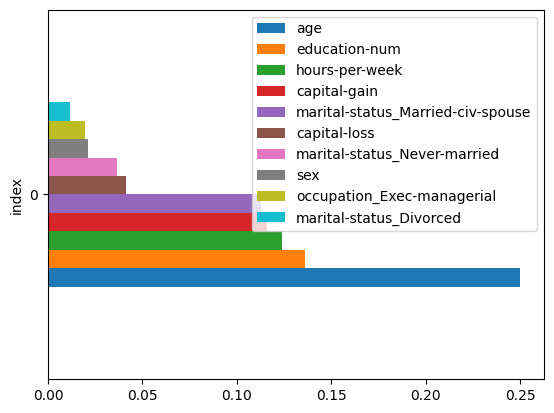

In [27]:
rf_importance(10)

In [28]:
# Use categories from your training set (already imputed)
workclass_choices = sorted(pd.unique(X_train["workclass"].dropna()))
sex_choices = sorted(pd.unique(X_train["sex"].dropna()))

demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Slider(17, 90, value=37, step=1, label="age"),
        gr.Slider(1, 80, value=40, step=1, label="hours_per_week"),
        gr.Slider(1, 16, value=10, step=1, label="education_num"),
        gr.Radio(list(sex_choices), label="sex"),
        gr.Dropdown(list(workclass_choices), label="workclass"),
        # Defaults for demo (you can expose these later in the UI)
        gr.Dropdown(X_train["marital-status"].unique(), label="marital-status"),
        gr.Dropdown(X_train["occupation"].unique(), label="occupation"),
        gr.Dropdown(X_train["native-country"].unique(), label="native-country"),
        gr.Number(label="capital-gain"),
        gr.Number(label="capital-loss"),
        gr.Slider(1, len(feature_order), value = 10, step=1, label="Number of Features"),
    ],
    outputs=[gr.Textbox(label="Model Output"), gr.Plot(label="Top n Features")],
    title="Income Classifier (Random Forest)",
    description="Baseline RF wrapped as a Gradio app. Shows label and P(>50K)."
)
"""
importance = gr.Interface(
        fn = rf_importance,
        inputs = gr.Slider(1, len(feature_order), step=1, label="Number of Features"),
        outputs = gr.DataFrame(label="Top n Features"),
        title = "Top n Features",
        description = "Top n features from Random Forest"
)
"""
demo.launch(share=True, show_error=True)  # use share=False if school network blocks external tunnels
#importance.launch(share=True, show_error=True)

/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1052: UserWarning:

Expected 12 arguments for function <function predict at 0x7ad6fb2a1f80>, received 11.

/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1056: UserWarning:

Expected at least 12 arguments for function <function predict at 0x7ad6fb2a1f80>, received 11.



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://227942c260576e91a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
with gr.Blocks(theme=gr.themes.Soft()) as demo_blocks:
    gr.Markdown("# Income Classifier (Random Forest)")

    with gr.Row():
        with gr.Column():
            age = gr.Slider(17, 90, value=37, step=1, label="age")
            hours_per_week = gr.Slider(1, 80, value=40, step=1, label="hours_per_week")
            education_num = gr.Slider(1, 16, value=10, step=1, label="education_num")
            sex = gr.Radio(list(sex_choices), label="sex")
            workclass = gr.Dropdown(list(workclass_choices), label="workclass")
            marital_status = gr.Dropdown(X_train["marital-status"].unique(), label="marital-status")
            occupation = gr.Dropdown(X_train["occupation"].unique(), label="occupation")
            native_country = gr.Dropdown(X_train["native-country"].unique(), label="native-country")
            capital_gain = gr.Number(label="capital-gain")
            capital_loss = gr.Number(label="capital-loss")
            num_features = gr.Slider(1, len(feature_order), value = 10, step=1, label="Number of Features")
            threshold = gr.Slider(0, 1, value = 0.5, step=0.01, label="Threshold")

            predict_button = gr.Button("Predict")

        with gr.Column():
            output_text = gr.Textbox(label="Model Output")
            feature_plot = gr.Plot(label="Top n Features")

    predict_button.click(
        fn=predict,
        inputs=[
            age, hours_per_week, education_num, sex, workclass,
            marital_status, occupation, native_country, capital_gain, capital_loss,
            num_features, threshold
        ],
        outputs=[output_text, feature_plot]
    )

demo_blocks.launch(share=True, show_error=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5faeaa9cf9a275bdc9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---

## 🌟 Stretch Challenge (pick one)

### A) Add more inputs
Expose `marital-status` and/or `occupation` in the UI. Update `predict` to pass them through `preprocess_input`.

**Hint:** Keep categorical choices from the training set to avoid unseen-label errors.

---

### B) Show **feature importance** (top-k)
After training, RF has `rf.feature_importances_`. Let users click a button to see the **top 10 features** your model relied on.

**How:**
- Create a small function that returns a table or text of the top-k from:
  - `pd.Series(rf.feature_importances_, index=X_train_final.columns).sort_values(ascending=False).head(10)`

**Optional UI idea:**
- Add a secondary `gr.Interface` or a `gr.Tab` / `gr.Accordion` that calls this function (e.g., `outputs="dataframe"` or text).
- Ask: *Does importance change if you retrain with different hyperparameters?*

> Note: RF importances are heuristic; they’re useful for discussion, not a complete story (advanced: SHAP later).

---

### C) Precision vs Recall slider (advanced)
Let the user pick a **threshold** for classifying `>50K` using `predict_proba`. Show how higher thresholds **increase precision** but **decrease recall**.

**How:**
- Add a slider 0.0–1.0 (“Decision Threshold for >50K”).
- If `P(>50K) ≥ threshold` → predict `>50K`, else `<=50K`.

**Discuss:** When would you prefer high precision vs high recall in a real app?

---

## Troubleshooting Tips
- **“unseen label” errors**: Make sure UI choices (e.g., `sex`, `workclass`) come from training categories.  
- **Wrong feature order**: Always reorder with `feature_order` before predicting.  
- **Variables not defined**: Re-run training/preprocessing cells above or import from your previous notebook.

---

### Exit Ticket (today)
- Launch your app and test 3 scenarios.
- Paste one app screenshot + a 2–3 sentence reflection in `students/experiment_log.md`.

In [30]:
from sklearn.svm import SVC
from sklearn.utils import resample # downsample the dataset
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix

In [31]:
y_train

,class
34342,<=50K
18559,<=50K
12477,<=50K
560,<=50K
3427,<=50K
...,...
38073,>50K
16306,>50K
26860,>50K
20602,<=50K


In [32]:
X_train_final

,age,hours-per-week,education-num,capital-gain,capital-loss,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,2.351033,-1.889257,-0.419324,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.579144,-2.453045,-1.584910,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.851333,-0.036809,-0.419324,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.313164,-0.036809,-0.419324,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.560209,-0.036809,1.134791,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,-0.414647,1.574016,-0.419324,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39069,1.259317,-0.036809,1.134791,-0.144218,-0.220137,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39070,-0.196304,-0.036809,-0.030796,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39071,-0.487428,-0.036809,-0.419324,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
y_train_index = y_train.reset_index(drop = True)
y_train_index

,class
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
39068,>50K
39069,>50K
39070,>50K
39071,<=50K


In [34]:
X_train_svm_bal = resample(X_train_final[y_train_index == ">50K"], replace = False, n_samples = 1000, random_state = 42)

In [35]:
X_train_svm_nbal = resample(X_train_final[y_train_index == "<=50K"], replace = False, n_samples = 1000, random_state = 42)

In [36]:
X_train_svm = pd.concat([X_train_svm_bal, X_train_svm_nbal])

In [37]:
y_train_svm = y_train_index.loc[X_train_svm.index]

In [38]:
X_train_svm

,age,hours-per-week,education-num,capital-gain,capital-loss,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
18623,0.531507,1.574016,1.134791,1.904767,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26702,0.094820,0.365897,-0.419324,-0.144218,4.397861,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34839,0.458726,-0.036809,1.134791,-0.144218,-0.220137,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8077,0.822631,0.607521,-0.419324,0.453948,-0.220137,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6202,-0.487428,-0.036809,1.523319,1.776569,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23419,-0.996895,-0.036809,-0.419324,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16012,-0.269085,-0.358974,-2.750496,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8124,-1.579144,-1.244927,-1.973439,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29638,-1.215239,-1.244927,-0.030796,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
y_test

,class
40342,<=50K
47680,<=50K
524,<=50K
8508,<=50K
31692,>50K
...,...
20384,<=50K
28000,<=50K
22163,>50K
24733,<=50K


In [40]:
y_test_index = y_test.reset_index(drop = True)
X_test_svm_bal = resample(X_test_final[y_test_index == ">50K"], replace = False, n_samples = 1000, random_state = 42)
X_test_svm_nbal = resample(X_test_final[y_test_index == "<=50K"], replace = False, n_samples = 1000, random_state = 42)
X_test_svm = pd.concat([X_test_svm_bal, X_test_svm_nbal])
y_test_svm = y_test_index.loc[X_test_svm.index]

In [41]:
y_test_svm

,class
2687,>50K
5936,>50K
1610,>50K
9632,>50K
1081,>50K
...,...
8336,<=50K
4369,<=50K
4048,<=50K
5419,<=50K


In [42]:
X_test_final

,age,hours-per-week,education-num,capital-gain,capital-loss,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,1.113755,-0.036809,-0.419324,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.778552,-1.647633,-0.419324,-0.144218,-0.220137,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.040974,0.768604,-0.030796,-0.144218,-0.220137,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.404879,-1.969798,-0.419324,0.283608,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.604288,-0.036809,0.746262,-0.144218,-0.220137,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,-1.288020,-1.647633,-0.030796,-0.144218,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9765,-0.487428,-0.358974,-0.419324,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9766,-0.196304,0.365897,1.523319,1.904767,-0.220137,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9767,2.423814,-2.291963,-0.419324,-0.144218,-0.220137,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
baller_svm = SVC(kernel = 'linear', probability = True)
baller_svm.fit(X_train_svm, y_train_svm)

SVC(kernel='linear', probability=True)

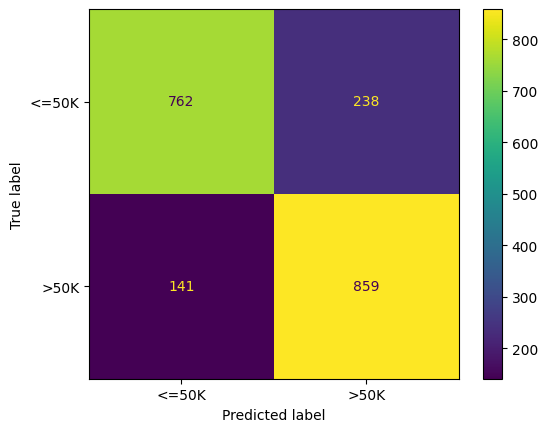

In [54]:
ConfusionMatrixDisplay.from_estimator(baller_svm, X_test_svm, y_test_svm)

In [55]:
from sklearn.metrics import classification_report

y_pred_svm = baller_svm.predict(X_test_svm)
print(classification_report(y_test_svm, y_pred_svm))

              precision    recall  f1-score   support

       <=50K       0.84      0.76      0.80      1000
        >50K       0.78      0.86      0.82      1000

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



In [49]:
"""
param_grid = [
  {'C': [0.5, 1, 10, 100], # NOTE: Values for C must be > 0
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
   'kernel': ['rbf', "linear"]},
]
optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy', ## (accruacy is default scoring) Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='balanced_accuracy', ## Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='f1', ## Terrible!!! C=0.5, gamma=1
        ##scoring='f1_micro', ## Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='f1_macro', ## Same!! C=1, gamma='scale' (these are the same as default values)
        ##scoring='f1_weighted', ## Same!! C=1, gamma='scale' (these are the same as default values)
        ##scoring='roc_auc', ## Terrible!!! C=1, gamma=0.001
        ## For more scoring metics see:
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
)
optimal_params.fit(X_train_svm, y_train_svm)
print(optimal_params.best_params_)
"""

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [56]:
baller_svmi = SVC(kernel = 'rbf', C = 1, gamma = 0.1, probability = True)
baller_svmi.fit(X_train_svm, y_train_svm)

SVC(C=1, gamma=0.1, probability=True)

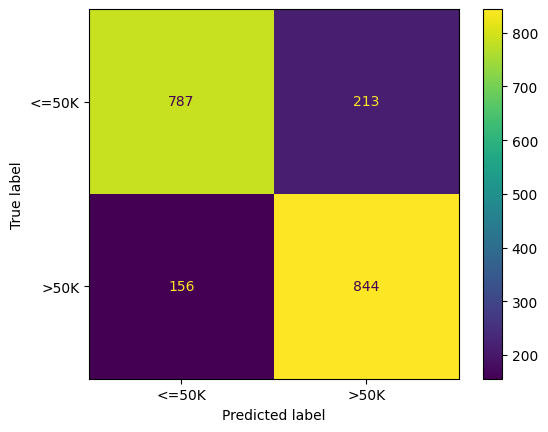

In [57]:
ConfusionMatrixDisplay.from_estimator(baller_svmi, X_test_svm, y_test_svm)

In [58]:
from sklearn.metrics import classification_report

y_pred_svm = baller_svmi.predict(X_test_svm)
print(classification_report(y_test_svm, y_pred_svm))

              precision    recall  f1-score   support

       <=50K       0.83      0.79      0.81      1000
        >50K       0.80      0.84      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [46]:
from google.colab import drive
drive.mount('/content/drive') # Mount your drive

Mounted at /content/drive


In [47]:
#change directory to where you want the model to be saved in your drive
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [48]:
import pickle
"""
print("SAVING COMPLETE MODEL PACKAGE")
print("=" * 50)

# Create a complete model package
model_package = {
    'model': rf,
    'preprocessors': {
        'num_imputer': num_imputer,
        'scaler': scaler,
        'cat_imputer': cat_imputer,
        'label_encoder': le,
        'onehot_encoder': ohe
    },
    'data': {
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train,
        'y_test': y_test
    }
}


with open('model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Saved: model_package.pkl")
"""

'\nprint("SAVING COMPLETE MODEL PACKAGE")\nprint("=" * 50)\n\n# Create a complete model package\nmodel_package = {\n    \'model\': rf,\n    \'preprocessors\': {\n        \'num_imputer\': num_imputer,\n        \'scaler\': scaler,\n        \'cat_imputer\': cat_imputer,\n        \'label_encoder\': le,\n        \'onehot_encoder\': ohe\n    },\n    \'data\': {\n        \'X_train\': X_train_final,\n        \'X_test\': X_test_final,\n        \'y_train\': y_train,\n        \'y_test\': y_test\n    }\n}\n\n\nwith open(\'model_package.pkl\', \'wb\') as f:\n    pickle.dump(model_package, f)\n\nprint("Saved: model_package.pkl")\n'

In [48]:
print("SAVING COMPLETE MODEL PACKAGE")
print("=" * 50)

# Create a complete model package
model_package = {
    'rf_model': rf,
    'svm_model': baller_svmi,
    'preprocessors': {
        'num_imputer': num_imputer,
        'scaler': scaler,
        'cat_imputer': cat_imputer,
        'label_encoder': le,
        'onehot_encoder': ohe
    },
    'data': {
        'X_train_final': X_train_final,
        'X_test_final': X_test_final,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_svm': X_train_svm,
        'y_train_svm': y_train_svm,
        'X_test_svm': X_test_svm,
        'y_test_svm': y_test_svm
    }
}


with open('model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Saved: model_package.pkl")